In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dependencies")
from music21 import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import warnings

%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.ssm_helper import *

sns.set_style("whitegrid")

warnings.filterwarnings("ignore")

SSM Code is based on exercise session materials

In [2]:
sample_score = converter.parse("data/asap-dataset/Schubert/Impromptu_op.90_D.899/3/xml_score.musicxml") # converter is from the music21 package
# linearized_sample_score = sample_score.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_sample_score = sample_score
# linearized_sample_score.show()

In [3]:
# Cast notes as MIDI note numbers
midi_sequence = []

for event in linearized_sample_score.recurse().notes:
    try:
        midi_sequence.append(event.pitch.midi)
    except:
        pass


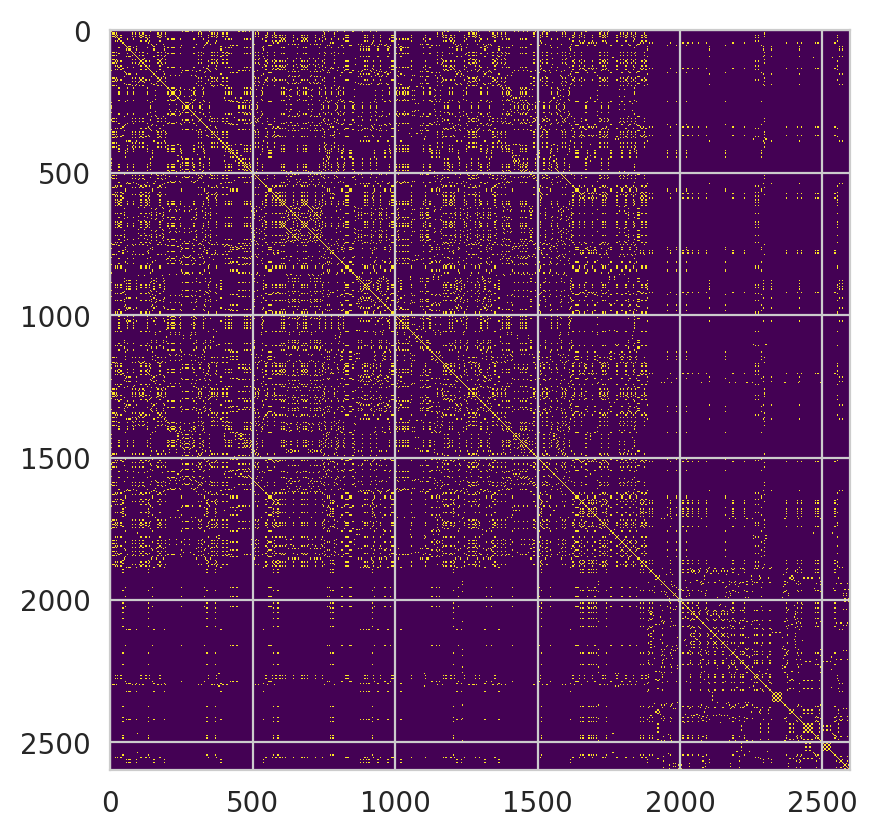

In [4]:

# Kronecker function for upcoming matrix (do not modify)
self_sim_mat1 = calculate_ssm(midi_sequence, kronecker_delta)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat1, cmap='viridis', interpolation='nearest')
# plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
# plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

In [5]:
# Cast measures as lists of MIDI note numbers

midi_measure_sequence = []
## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
for measure in linearized_sample_score.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure):
    measure_midi_list = []
    for event in measure.recurse().notes:
        try:
            measure_midi_list.append(event.pitch.midi)
        except:
            if isinstance(event, chord.Chord):
                for pitch in event.pitches:
                    measure_midi_list.append(pitch.midi)
    midi_measure_sequence.append(measure_midi_list)

# join measures 69/70 and 81/82 -- fixes bug in measure numbers
m69 = midi_measure_sequence[68] + midi_measure_sequence[69]
m81 = midi_measure_sequence[80] + midi_measure_sequence[81]

midi_measure_sequence[80] = m81
midi_measure_sequence.pop(81)
midi_measure_sequence[68] = m69
midi_measure_sequence.pop(69)

print(len(midi_measure_sequence))

86


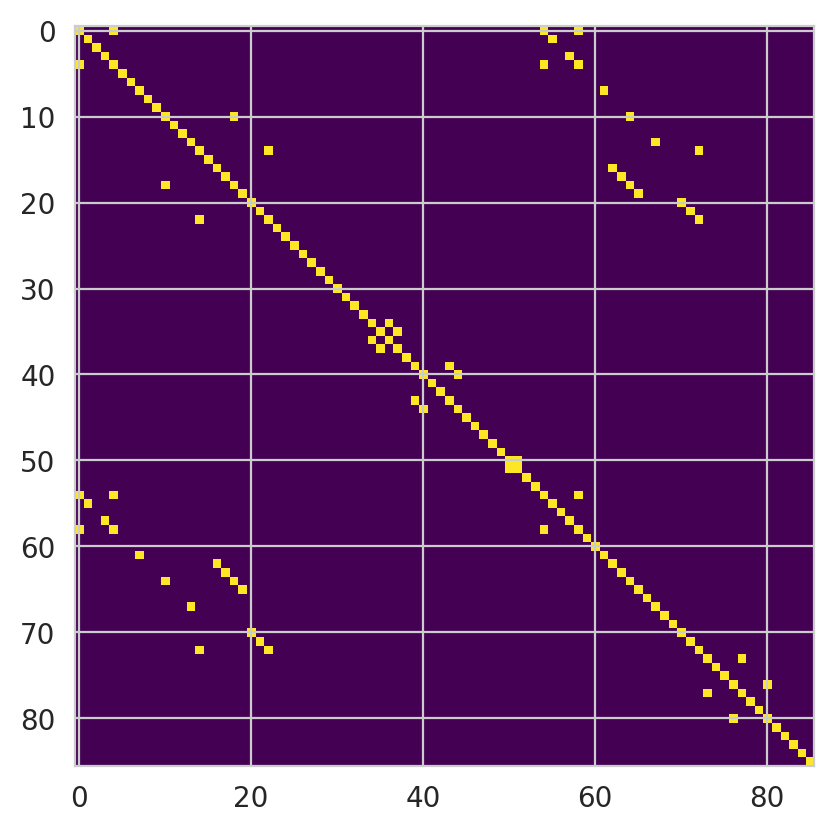

In [6]:
# Create similarity matrix from MIDI measure lists
self_sim_mat2_kron = calculate_ssm(midi_measure_sequence, kronecker_delta)

plt.imshow(self_sim_mat2_kron, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

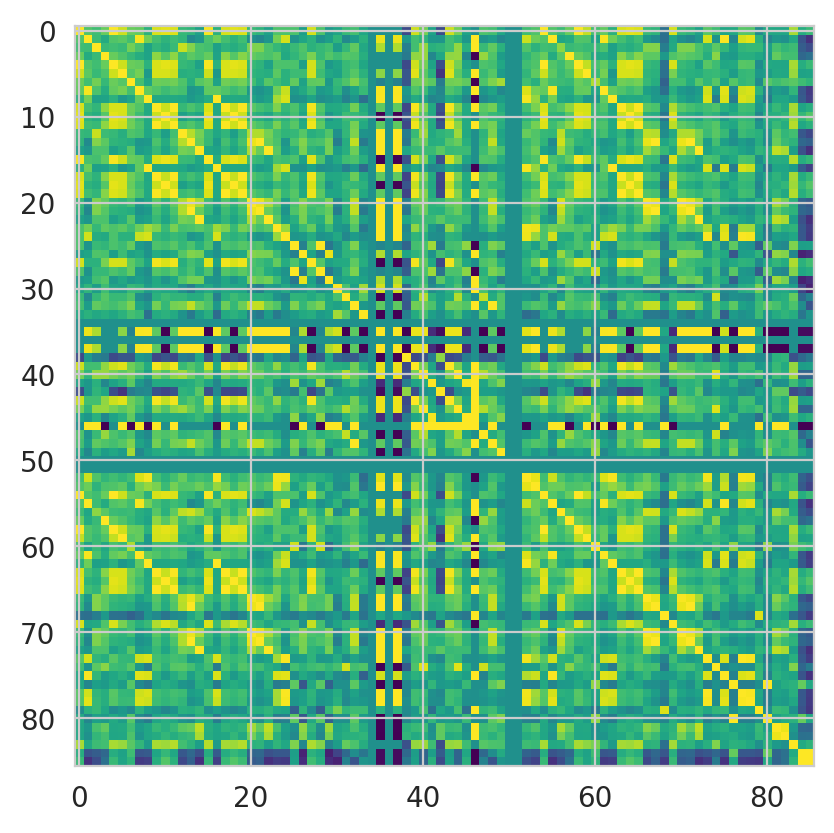

In [7]:
self_sim_mat2_corr = calculate_ssm(midi_measure_sequence, calculate_correlation)

plt.imshow(self_sim_mat2_corr, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

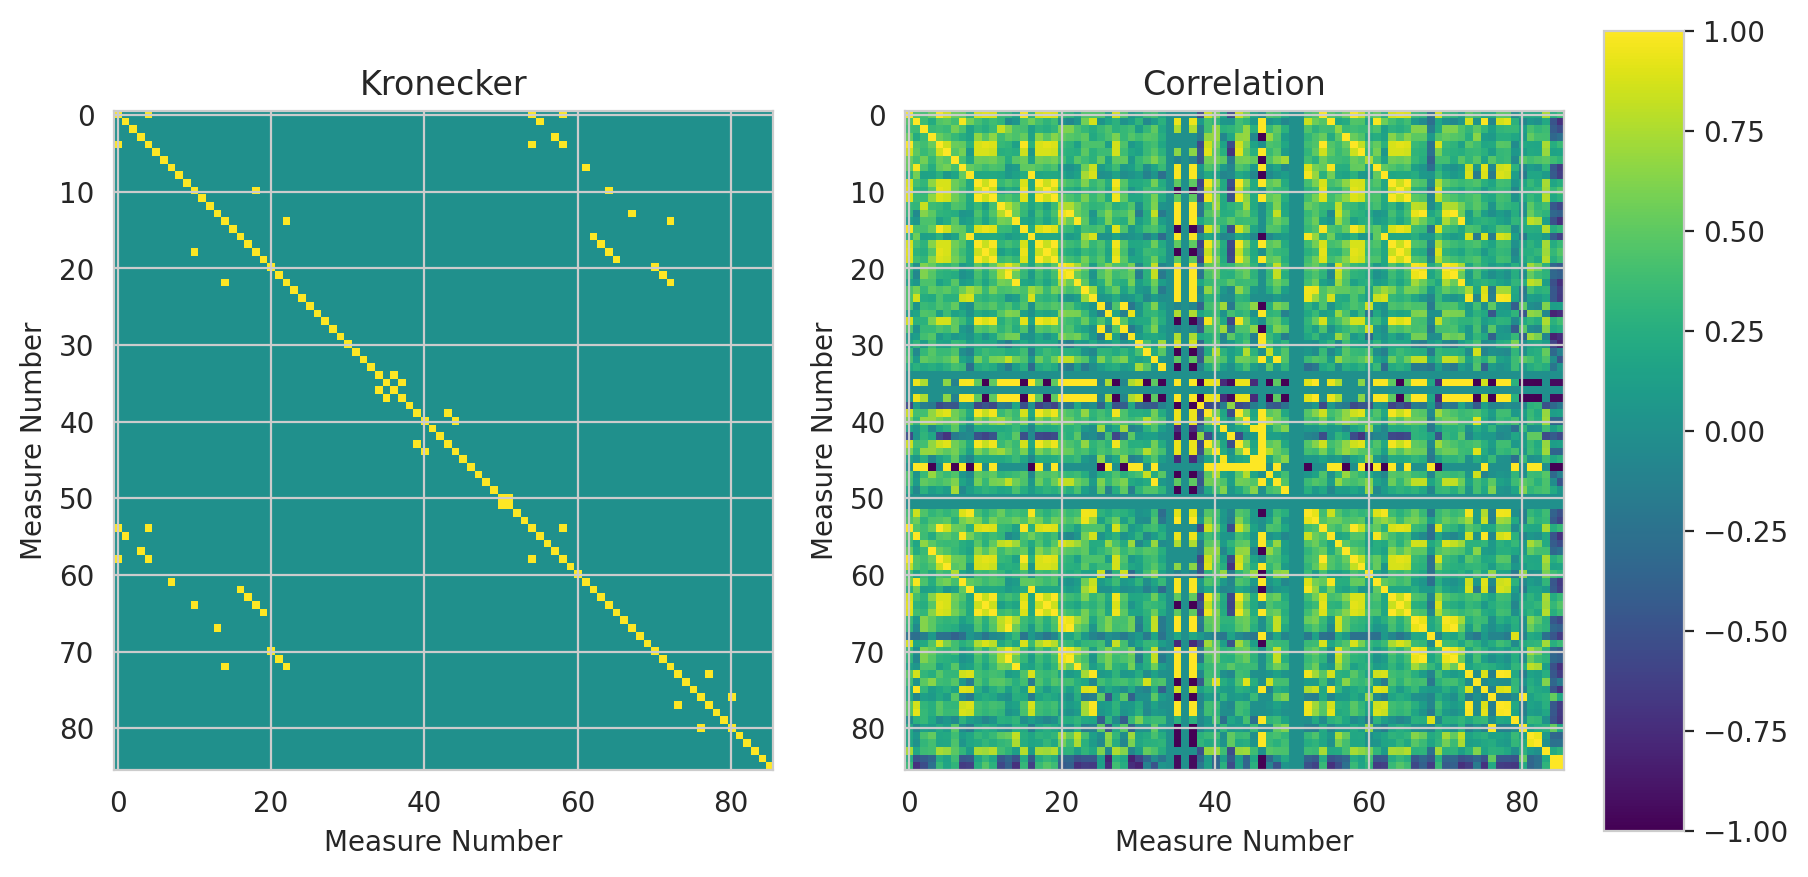

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

im1 = axes[0].imshow(self_sim_mat2_kron, vmin=-1, vmax=1, cmap='viridis', interpolation='nearest')
im2 = axes[1].imshow(self_sim_mat2_corr, vmin=-1, vmax=1, cmap='viridis', interpolation='nearest')

axes[0].set_xlabel("Measure Number")
axes[1].set_xlabel("Measure Number")
axes[0].set_ylabel("Measure Number")
axes[1].set_ylabel("Measure Number")

axes[0].set_title("Kronecker")
axes[1].set_title("Correlation")

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.3, 0.04, 0.4])
fig.colorbar(im2, cax=cbar_ax)
#fig.tight_layout()

plt.savefig("report/matrix.pdf", dpi=600, bbox_inches='tight', pad_inches=0)

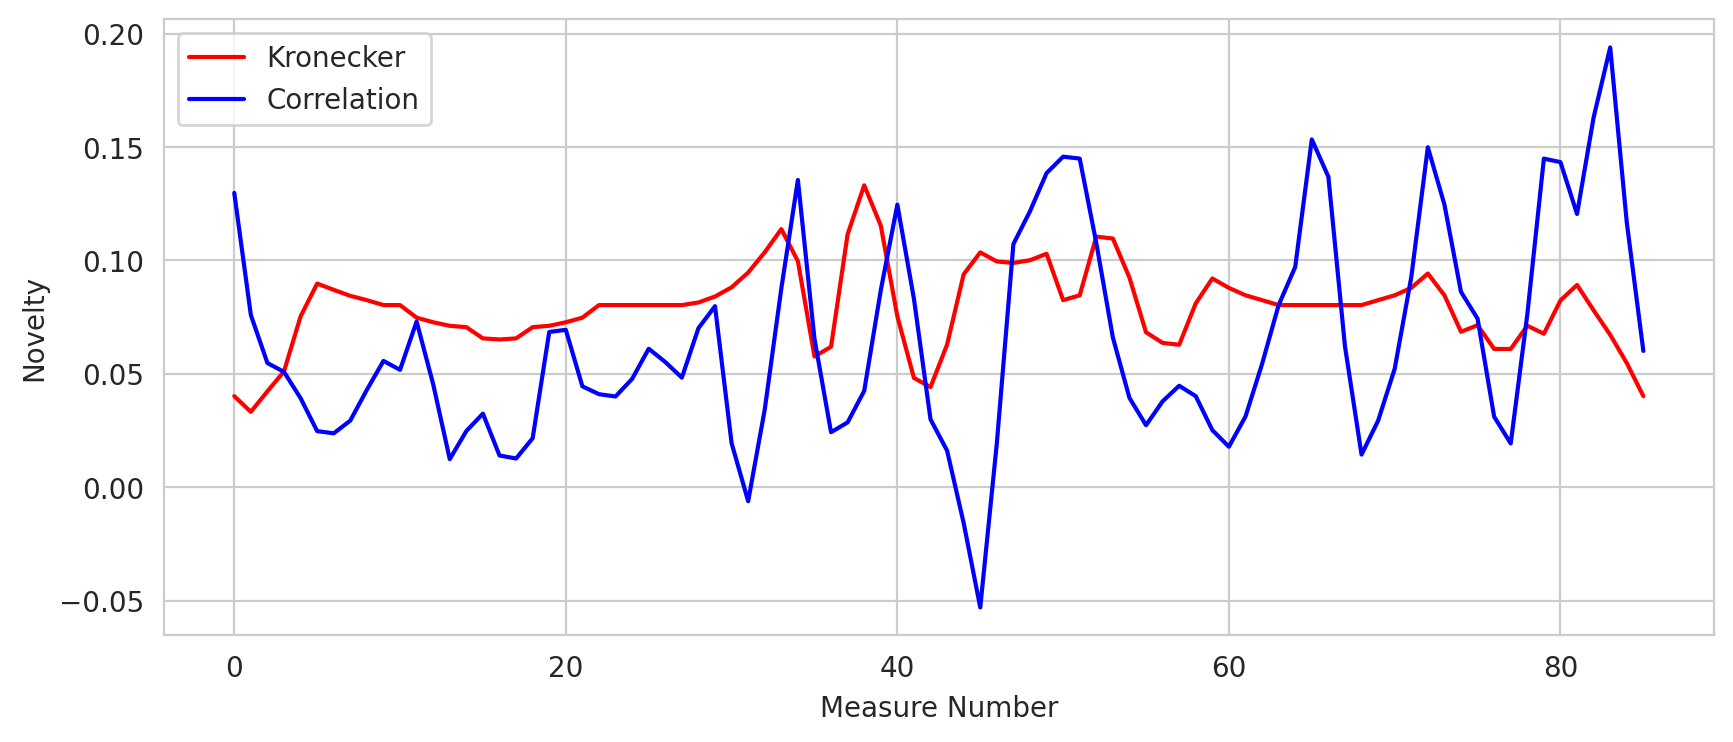

In [9]:
L_kernel = int(self_sim_mat2_kron.shape[0] / 10)
nov_kron = compute_novelty_ssm(self_sim_mat2_kron, L=L_kernel, exclude=False)
nov_corr = compute_novelty_ssm(self_sim_mat2_corr, L=L_kernel, exclude=False)   


plt.figure(figsize=(10, 4))
plt.plot(nov_kron, color="red", label="Kronecker")
plt.plot(nov_corr, color="blue", label="Correlation")
plt.ylabel('Novelty')
plt.xlabel('Measure Number')
plt.legend()
plt.savefig("report/novelty.pdf", dpi=600)

In [10]:
get_novelty_topk(nov_kron, 10)

array([32, 33, 37, 38, 39, 45, 48, 49, 52, 53])

In [11]:
get_novelty_topk(nov_corr, 3)

array([65, 82, 83])

In [12]:
get_novelty_threshold(nov_kron, 0.037)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

In [13]:
get_novelty_threshold(nov_corr, 0.03)

array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 12, 15, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 32, 33, 34, 35, 38, 39, 40, 41, 47, 48, 49, 50,
       51, 52, 53, 54, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72,
       73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85])

In [14]:
get_novelty_threshold(-nov_corr, -0.030)

array([ 5,  6,  7, 13, 14, 16, 17, 18, 30, 31, 36, 37, 42, 43, 44, 45, 46,
       55, 59, 60, 68, 69, 77])

In [15]:
nov_corr.shape

(86,)

## Nested Version

In [16]:
def get_measure_numbers(sim_mat, kernel_size=10, k=3):
    print(sim_mat.shape, "AAAA")
    nov = compute_novelty_ssm(sim_mat, L=kernel_size, exclude=False)   
    return get_novelty_topk(nov, k).tolist()

In [17]:
self_sim_mat2_corr.shape[0]

86

In [18]:
def nested_kernels(sim_mat, level, start_index, end_index, full_matrix):
    kernel_size = int(sim_mat.shape[0] / 10)

    print("shape", sim_mat.shape, "level",level)

    if sim_mat.shape[0] <= 6:
        return [start_index, end_index]

    boundaries = get_measure_numbers(sim_mat, kernel_size=kernel_size, k=2)
    
    # go back to original indexing
    boundaries = [elem + start_index for elem in boundaries]
    print("Boundaries", boundaries)

    boundaries = boundaries + [end_index]

    new_mat_list = []
    start_index_list = []
    end_index_list = []
    prev_boundary = start_index
    for boundary in boundaries:
        print("index", prev_boundary, boundary, start_index, end_index)
        new_mat = full_matrix[prev_boundary:boundary, prev_boundary:boundary]
        new_mat_list.append(new_mat)
        start_index_list.append(prev_boundary)
        end_index_list.append(boundary)
        
        prev_boundary = boundary

    final_boundaries = []

    for new_mat, new_start_index, new_end_index in zip(new_mat_list, start_index_list, end_index_list):
        new_boundaries = nested_kernels(new_mat, level+1, new_start_index, new_end_index, full_matrix)
        final_boundaries.extend(new_boundaries)

    print(final_boundaries)

    return sorted(set(final_boundaries))
        



In [19]:
sorted(set({1, 2, 3}))

[1, 2, 3]

In [20]:
corr_nested_version = nested_kernels(self_sim_mat2_corr, 0, 0, self_sim_mat2_corr.shape[0], full_matrix=self_sim_mat2_corr)

shape (86, 86) level 0
(86, 86) AAAA
Boundaries [82, 83]
index 0 82 0 86
index 82 83 0 86
index 83 86 0 86
shape (82, 82) level 1
(82, 82) AAAA
Boundaries [65, 72]
index 0 65 0 82
index 65 72 0 82
index 72 82 0 82
shape (65, 65) level 2
(65, 65) AAAA
Boundaries [34, 51]
index 0 34 0 65
index 34 51 0 65
index 51 65 0 65
shape (34, 34) level 3
(34, 34) AAAA
Boundaries [11, 19]
index 0 11 0 34
index 11 19 0 34
index 19 34 0 34
shape (11, 11) level 4
(11, 11) AAAA
Boundaries [7, 9]
index 0 7 0 11
index 7 9 0 11
index 9 11 0 11
shape (7, 7) level 5
(7, 7) AAAA
Boundaries [5, 6]
index 0 5 0 7
index 5 6 0 7
index 6 7 0 7
shape (5, 5) level 6
shape (1, 1) level 6
shape (1, 1) level 6
[0, 5, 5, 6, 6, 7]
shape (2, 2) level 5
shape (2, 2) level 5
[0, 5, 6, 7, 7, 9, 9, 11]
shape (8, 8) level 4
(8, 8) AAAA
Boundaries [17, 18]
index 11 17 11 19
index 17 18 11 19
index 18 19 11 19
shape (6, 6) level 5
shape (1, 1) level 5
shape (1, 1) level 5
[11, 17, 17, 18, 18, 19]
shape (15, 15) level 4
(15, 15) A

In [21]:
kron_nested_version = nested_kernels(self_sim_mat2_kron, 0, 0, self_sim_mat2_kron.shape[0], full_matrix=self_sim_mat2_kron)

shape (86, 86) level 0
(86, 86) AAAA
Boundaries [38, 39]
index 0 38 0 86
index 38 39 0 86
index 39 86 0 86
shape (38, 38) level 1
(38, 38) AAAA
Boundaries [33, 34]
index 0 33 0 38
index 33 34 0 38
index 34 38 0 38
shape (33, 33) level 2
(33, 33) AAAA
Boundaries [16, 18]
index 0 16 0 33
index 16 18 0 33
index 18 33 0 33
shape (16, 16) level 3
(16, 16) AAAA
Boundaries [13, 14]
index 0 13 0 16
index 13 14 0 16
index 14 16 0 16
shape (13, 13) level 4
(13, 13) AAAA
Boundaries [10, 11]
index 0 10 0 13
index 10 11 0 13
index 11 13 0 13
shape (10, 10) level 5
(10, 10) AAAA
Boundaries [7, 8]
index 0 7 0 10
index 7 8 0 10
index 8 10 0 10
shape (7, 7) level 6
(7, 7) AAAA
Boundaries [5, 6]
index 0 5 0 7
index 5 6 0 7
index 6 7 0 7
shape (5, 5) level 7
shape (1, 1) level 7
shape (1, 1) level 7
[0, 5, 5, 6, 6, 7]
shape (1, 1) level 6
shape (2, 2) level 6
[0, 5, 6, 7, 7, 8, 8, 10]
shape (1, 1) level 5
shape (2, 2) level 5
[0, 5, 6, 7, 8, 10, 10, 11, 11, 13]
shape (1, 1) level 4
shape (2, 2) level 4
[

## Create TikZ

In [22]:
from src.phrase_tikz import convert_list_to_tikz

In [28]:
kronecker_version = get_novelty_threshold(nov_kron, 0.037)

convert_list_to_tikz(kronecker_version, "alg_kron_phrases.tex")

In [29]:
correlation_version = get_novelty_threshold(nov_corr, 0.03)

convert_list_to_tikz(correlation_version, "alg_corr_phrases.tex")

In [30]:
convert_list_to_tikz(kron_nested_version, "alg_kron_phrases.tex")

In [31]:
convert_list_to_tikz(corr_nested_version, "alg_corr_phrases.tex")